In [81]:

import json, math
import torch
import matplotlib.pyplot as plt

device = "cpu"
dtype  = torch.float64


In [5]:
with open("patient_information.json") as f:
    patient = json.load(f)

with open("model.json") as f:
    model = json.load(f)


In [82]:
state_names = list(model["states"].keys())
n_states    = len(state_names)

state_index = {name: i for i, name in enumerate(state_names)}

# Control channels (Adr, Cyc, Tax, Tam, IO, TIL)
control_channels = model["control_spec"]["channels"]
control_index    = {name: i for i, name in enumerate(control_channels)}

print("States:", state_names)
print("State index:", state_index)
print("Control channels:", control_channels)


States: ['T', 'E', 'H', 'PDL1', 'TGFb', 'ctDNA', 'Adr', 'Cyc', 'Tax', 'Tam', 'IO', 'TIL', 'N', 'BM']
State index: {'T': 0, 'E': 1, 'H': 2, 'PDL1': 3, 'TGFb': 4, 'ctDNA': 5, 'Adr': 6, 'Cyc': 7, 'Tax': 8, 'Tam': 9, 'IO': 10, 'TIL': 11, 'N': 12, 'BM': 13}
Control channels: ['Adr', 'Cyc', 'Tax', 'Tam', 'IO', 'TIL']


In [83]:
def get_initial_state_vector(model, patient, device=device, dtype=dtype):
    ic_patient = patient["initial_conditions"]
    x0 = torch.zeros(n_states, dtype=dtype, device=device)
    for s in state_names:
        x0[state_index[s]] = ic_patient[s]
    return x0

x0 = get_initial_state_vector(model, patient)
x0


tensor([0.1800, 0.3000, 0.5000, 0.5000, 0.0000, 0.0300, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.5000, 0.8000], dtype=torch.float64)

In [84]:

def get_teacher_params(model, device=device, dtype=dtype):
    theta = {}
    for name, info in model["parameters"].items():
        if "value" in info:
            val = info["value"]
        else:
            val = info.get("initial_guess", 0.0)
        theta[name] = torch.tensor(val, dtype=dtype, device=device)
    return theta

theta = get_teacher_params(model)
list(theta.items())[:10]  # peek


[('rT_max', tensor(0.0500, dtype=torch.float64)),
 ('k_ET', tensor(0.5000, dtype=torch.float64)),
 ('K_ET', tensor(0.2000, dtype=torch.float64)),
 ('k_Tam_ERPR', tensor(0.3000, dtype=torch.float64)),
 ('K_Tam', tensor(0.3000, dtype=torch.float64)),
 ('rE_max', tensor(0.1000, dtype=torch.float64)),
 ('rH_max', tensor(0.0600, dtype=torch.float64)),
 ('delta_E', tensor(0.0300, dtype=torch.float64)),
 ('delta_H', tensor(0.0200, dtype=torch.float64)),
 ('k_T_to_E', tensor(0.2000, dtype=torch.float64))]

In [85]:

eps = 1e-8

def Hill(x, K, n):
    # x, K, n can be scalars/tensors; broadcasting works
    return x**n / (K**n + x**n + eps)

def Sat(x, K):
    return x / (K + x + eps)

def g_N(N, theta):
    # Nutrient term for proliferation, using K_N_prolif
    return Sat(N, theta["K_N_prolif"])

def g_BM(BM, theta):
    return BM**theta["n_BM"] / (theta["K_BM"]**theta["n_BM"] + BM**theta["n_BM"] + eps)

def g_TGFb(TGFb, theta):
    return Hill(TGFb, theta["K_TGFb"], theta["n_TGFb"])

def S_IO(IO, theta):
    return Hill(IO, theta["K_IO"], theta["n_IO"])

def S_PDL1(PDL1, theta):
    return Hill(PDL1, theta["K_PDL1"], theta["n_PDL1"])

def S_Adr(Adr, theta):
    return theta["Emax_Adr"] * Hill(Adr, theta["EC50_Adr"], theta["n_Adr"])

def S_Cyc(Cyc, theta):
    return theta["Emax_Cyc"] * Hill(Cyc, theta["EC50_Cyc"], theta["n_Cyc"])

def S_Tax(Tax, theta):
    return theta["Emax_Tax"] * Hill(Tax, theta["EC50_Tax"], theta["n_Tax"])


In [87]:

t0_sim    = patient["tgrid"]["start_day"]
dt_sim    = patient["tgrid"]["step_days"]
num_days  = patient["tgrid"]["num_days"]
t_end_sim = t0_sim + dt_sim * (num_days - 1)

def square_pulse(t, center_day, width_days, amplitude):
    """
    Square pulse of height 'amplitude' active for |t - center| <= width/2.
    t can be a scalar or 0-D tensor.
    """
    if not torch.is_tensor(t):
        t = torch.tensor(float(t), dtype=dtype, device=device)
    half_w = 0.5 * width_days
    cond = (t >= center_day - half_w) & (t <= center_day + half_w)
    return amplitude * cond.to(dtype)

def ac_t_io_til_schedule(t):
    # Arbitrary doses (just to generate trajectories)
    Adr_dose = torch.tensor(1.0, dtype=dtype, device=device)
    Cyc_dose = torch.tensor(1.0, dtype=dtype, device=device)
    Tax_dose = torch.tensor(0.8, dtype=dtype, device=device)
    Tam_dose = torch.tensor(0.3, dtype=dtype, device=device)
    IO_dose  = torch.tensor(0.5, dtype=dtype, device=device)
    TIL_dose = torch.tensor(0.5, dtype=dtype, device=device)

    # AC q14d x4, starting day 0
    ac_centers = [t0_sim + 14.0*i for i in range(4)]
    u_Adr = sum(square_pulse(t, c, 1.0, Adr_dose) for c in ac_centers)
    u_Cyc = sum(square_pulse(t, c, 1.0, Cyc_dose) for c in ac_centers)

    # Tax weekly x12, starting day 56
    tax_centers = [t0_sim + 56.0 + 7.0*i for i in range(12)]
    u_Tax = sum(square_pulse(t, c, 1.0, Tax_dose) for c in tax_centers)

    # Tam continuous low dose from day 56 onward
    t_tensor = t if torch.is_tensor(t) else torch.tensor(float(t), dtype=dtype, device=device)
    u_Tam = Tam_dose * (t_tensor >= t0_sim + 56.0).to(dtype)

    # IO q21d x6
    io_centers = [t0_sim + 21.0*i for i in range(6)]
    u_IO = sum(square_pulse(t, c, 1.0, IO_dose) for c in io_centers)

    # Single TIL infusion at day 10
    til_center = t0_sim + 10.0
    u_TIL = square_pulse(t, til_center, 1.0, TIL_dose)

    return {
        "Adr": u_Adr,
        "Cyc": u_Cyc,
        "Tax": u_Tax,
        "Tam": u_Tam,
        "IO":  u_IO,
        "TIL": u_TIL,
    }

u_schedule = ac_t_io_til_schedule


In [88]:
# -----------------------------------------------------------
# Delayed version: no treatment for first 20 days,
# then start the exact same AC–T + IO + TIL pattern.
# -----------------------------------------------------------

def delayed_ac_t_io_til_schedule(t, delay_days=20.0):
    # Make sure we have a scalar float time
    if torch.is_tensor(t):
        t_float = float(t.detach().cpu().item())
    else:
        t_float = float(t)

    # Before delay_days: no treatment → all zeros
    if t_float < t0_sim + delay_days:
        zero = torch.tensor(0.0, dtype=dtype, device=device)
        return {
            "Adr": zero,
            "Cyc": zero,
            "Tax": zero,
            "Tam": zero,
            "IO":  zero,
            "TIL": zero,
        }

    # After delay_days: run your original schedule,
    # but with time shifted by delay_days so AC, Tax, IO, TIL
    # all start later.
    shifted_t = t_float - delay_days
    return ac_t_io_til_schedule(shifted_t)


In [89]:
u_schedule = delayed_ac_t_io_til_schedule

In [90]:
# teacher ODE
def f_teacher(x, t, theta, u_fn):
    # Unpack state vector
    T    = x[..., state_index["T"]]
    E    = x[..., state_index["E"]]
    H    = x[..., state_index["H"]]
    PDL1 = x[..., state_index["PDL1"]]
    TGFb = x[..., state_index["TGFb"]]
    ct   = x[..., state_index["ctDNA"]]
    Adr  = x[..., state_index["Adr"]]
    Cyc  = x[..., state_index["Cyc"]]
    Tax  = x[..., state_index["Tax"]]
    Tam  = x[..., state_index["Tam"]]
    IO   = x[..., state_index["IO"]]
    TIL  = x[..., state_index["TIL"]]
    N    = x[..., state_index["N"]]
    BM   = x[..., state_index["BM"]]

    # Controls u_Drug(t)
    u = u_fn(t)
    zero = torch.tensor(0.0, dtype=dtype, device=device)
    u_Adr = u.get("Adr", zero)
    u_Cyc = u.get("Cyc", zero)
    u_Tax = u.get("Tax", zero)
    u_Tam = u.get("Tam", zero)
    u_IO  = u.get("IO",  zero)
    u_TIL = u.get("TIL", zero)

    # Helper signals
    gN   = g_N(N, theta)
    gBM  = g_BM(BM, theta)
    gTGF = g_TGFb(TGFb, theta)
    SIO  = S_IO(IO, theta)
    SP   = S_PDL1(PDL1, theta)

    SAdr   = S_Adr(Adr, theta)
    SCyc   = S_Cyc(Cyc, theta)
    STax   = S_Tax(Tax, theta)
    Schemo = SAdr + SCyc + STax

    # 1) Tumor T
    rT_max      = theta["rT_max"]
    k_ET        = theta["k_ET"]
    K_ET        = theta["K_ET"]
    k_PDboost_T = theta["k_PDboost_T"]
    k_Tam_ERPR  = theta["k_Tam_ERPR"]
    K_Tam       = theta["K_Tam"]

    growth_T    = rT_max * gN * (1.0 + k_PDboost_T * SP) * T * (1.0 - T)
    immune_kill = k_ET * (E * T) / (K_ET + T + eps)
    chemo_kill  = Schemo * T
    tam_kill    = k_Tam_ERPR * Sat(Tam, K_Tam) * T

    dT = growth_T - immune_kill - chemo_kill - tam_kill

    # 2) Effector E
    rE_max    = theta["rE_max"]
    delta_E   = theta["delta_E"]
    k_T_to_E  = theta["k_T_to_E"]
    K_Tstim_E = theta["K_Tstim_E"]
    k_H_to_E  = theta["k_H_to_E"]
    K_Hboost_E = theta["K_Hboost_E"]
    phi_TGFb   = theta["phi_TGFb"]
    gamma_IO   = theta["gamma_IO"]

    Stim_E_from_T = k_T_to_E * Sat(T, K_Tstim_E) * E
    Stim_E_from_H = k_H_to_E * Sat(H, K_Hboost_E) * E

    Growth_base = rE_max * gN * gBM * (1.0 - phi_TGFb * gTGF) * (1.0 + gamma_IO * SIO) * E
    Loss_base   = delta_E * (1.0 + SP) * E

    dE = Growth_base + Stim_E_from_T + Stim_E_from_H - Loss_base

    # 3) Helper H
    rH_max    = theta["rH_max"]
    delta_H   = theta["delta_H"]
    k_T_to_H  = theta["k_T_to_H"]
    K_Tstim_H = theta["K_Tstim_H"]

    Stim_H_from_T = k_T_to_H * Sat(T, K_Tstim_H) * H
    Growth_H      = rH_max * gN * gBM * (1.0 - phi_TGFb * gTGF) * H
    Loss_H        = delta_H * H

    dH = Growth_H + Stim_H_from_T - Loss_H

    # 4) PD-L1
    PDL1_basal      = theta["PDL1_basal"]
    k_PDL1_up_T     = theta["k_PDL1_up_T"]
    K_PDL1_up_T     = theta["K_PDL1_up_T"]
    k_PDL1_up_E     = theta["k_PDL1_up_E"]
    K_PDL1_up_E     = theta["K_PDL1_up_E"]
    k_PDL1_decay    = theta["k_PDL1_decay"]
    k_IO_block_PDL1 = theta["k_IO_block_PDL1"]

    dPDL1 = (
        PDL1_basal
        + k_PDL1_up_T * Sat(T, K_PDL1_up_T)
        + k_PDL1_up_E * Sat(E, K_PDL1_up_E)
        - k_PDL1_decay * PDL1
        - k_IO_block_PDL1 * SIO * PDL1
    )

    # 5) TGF-b
    k_T_secrete_TGFb = theta["k_T_secrete_TGFb"]
    k_TGFb_decay     = theta["k_TGFb_decay"]

    dTGFb = k_T_secrete_TGFb * T - k_TGFb_decay * TGFb

    # 6) ctDNA
    p_ct   = theta["p_ct"]
    k_ctclr = theta["k_ctclr"]

    dct = p_ct * T - k_ctclr * ct

    # 7) Nutrient N
    sN          = theta["sN"]
    dN_param    = theta["dN"]
    K_N_use_T   = theta["K_N_use_T"]
    K_N_use_E   = theta["K_N_use_E"]
    chi_N_chemo = theta["chi_N_chemo"]

    Tumor_use = N * T / (K_N_use_T + T + eps)
    Eff_use   = N * E / (K_N_use_E + E + eps)

    dNdt = sN - dN_param * N - Tumor_use - Eff_use - chi_N_chemo * Schemo * N

    # 8) BM
    sBM          = theta["sBM"]
    dBM_param    = theta["dBM"]
    qBM_chemo    = theta["qBM_chemo"]
    gamma_BM_IO  = theta["gamma_BM_IO"]
    gamma_BM_TIL = theta["gamma_BM_TIL"]
    K_TIL        = theta["K_TIL"]

    Support_IO  = gamma_BM_IO  * SIO * (1.0 - BM)
    Support_TIL = gamma_BM_TIL * Sat(TIL, K_TIL) * (1.0 - BM)

    dBMdt = sBM - dBM_param * BM - qBM_chemo * Schemo * BM + Support_IO + Support_TIL

    # 9) Drug PK
    lambda_Adr = theta["lambda_Adr"]
    lambda_Cyc = theta["lambda_Cyc"]
    lambda_Tax = theta["lambda_Tax"]
    lambda_Tam = theta["lambda_Tam"]
    lambda_IO  = theta["lambda_IO"]
    lambda_TIL = theta["lambda_TIL"]

    dAdr = u_Adr - lambda_Adr * Adr
    dCyc = u_Cyc - lambda_Cyc * Cyc
    dTax = u_Tax - lambda_Tax * Tax
    dTam = u_Tam - lambda_Tam * Tam
    dIO  = u_IO  - lambda_IO  * IO
    dTIL = u_TIL - lambda_TIL * TIL

    # Pack derivatives
    dxdt = torch.stack([
        dT, dE, dH, dPDL1, dTGFb, dct,
        dAdr, dCyc, dTax, dTam, dIO, dTIL,
        dNdt, dBMdt
    ], dim=-1)

    return dxdt


In [91]:

def rk4_step(f, x, t, dt, theta, u_fn):
    k1 = f(x,             t,           theta, u_fn)
    k2 = f(x + 0.5*dt*k1, t + 0.5*dt,  theta, u_fn)
    k3 = f(x + 0.5*dt*k2, t + 0.5*dt,  theta, u_fn)
    k4 = f(x + dt*k3,     t + dt,      theta, u_fn)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# Indices to clamp in [0,1] (T, PDL1, TGFb, ctDNA, N, BM)
clamp_indices = [
    state_index["T"],
    state_index["PDL1"],
    state_index["TGFb"],
    state_index["ctDNA"],
    state_index["N"],
    state_index["BM"],
]

def clamp_states(x):
    x_cl = x.clone()
    x_cl[..., clamp_indices] = x_cl[..., clamp_indices].clamp(0.0, 1.0)
    return x_cl


In [92]:
def simulate_teacher(model, patient, theta, u_fn,
                     device=device, dtype=dtype):
    tgrid = patient["tgrid"]
    t0    = tgrid["start_day"]
    num   = tgrid["num_days"]
    dt    = tgrid["step_days"]

    times = torch.linspace(t0, t0 + dt*(num-1),
                           num, device=device, dtype=dtype)

    x0 = get_initial_state_vector(model, patient, device=device, dtype=dtype)

    xs = [x0]   # python list, no inplace ops
    x  = x0

    for i in range(num-1):
        t = times[i]
        x_next = rk4_step(f_teacher, x, t, dt, theta, u_fn)
        x_next = clamp_states(x_next)
        xs.append(x_next)
        x = x_next

    x_out = torch.stack(xs, dim=0)
    return times, x_out

times, x_data = simulate_teacher(model, patient, theta, u_schedule)

times.shape, x_data.shape


(torch.Size([365]), torch.Size([365, 14]))

In [93]:
T_full = times.shape[0]
T_sub  = min(T_full, 365)  # e.g. first 90 timepoints

times_fit  = times[:T_sub]
x_data_fit = x_data[:T_sub]

def simulate_with_theta_prefix(theta_dict):
    # simulate full, then cut to prefix to match x_data_fit
    times_pred, x_pred = simulate_teacher(
        model, patient, theta_dict, u_schedule,
        device=device, dtype=dtype
    )
    return times_pred[:T_sub], x_pred[:T_sub]

In [94]:
import torch

def build_feature_library(x):
    """
    x: tensor [T, n_states]
    Returns:
        Phi: [T, n_features]
        names: list of feature names
    """
    T, n = x.shape
    features = []
    names = []

    # 1: constant term
    features.append(torch.ones((T,1), dtype=x.dtype, device=x.device))
    names.append("1")

    # 2: linear terms
    for i in range(n):
        features.append(x[:, i:i+1])
        names.append(f"x_{i}")

    # 3: quadratic terms
    for i in range(n):
        for j in range(i, n):
            features.append(x[:, i:i+1] * x[:, j:j+1])
            names.append(f"x_{i}*x_{j}")

    Phi = torch.cat(features, dim=1)
    return Phi, names


In [95]:
def compute_time_derivative(times, x):
    dt = times[1] - times[0]
    dxdt = torch.zeros_like(x)

    dxdt[1:-1] = (x[2:] - x[:-2]) / (2*dt)
    dxdt[0]    = (x[1] - x[0]) / dt
    dxdt[-1]   = (x[-1] - x[-2]) / dt
    return dxdt

dxdt_data = compute_time_derivative(times, x_data)


In [96]:
Phi, Phi_names = build_feature_library(x_data)

n_states = x_data.shape[1]
n_features = Phi.shape[1]

W = torch.nn.Parameter(torch.zeros(n_states, n_features, 
                                   dtype=x_data.dtype, device=x_data.device))
optimizer = torch.optim.Adam([W], lr=1e-2)


In [97]:
def predict_dxdt(Phi, W):
    return Phi @ W.T


In [98]:
num_iters = 5000
for it in range(num_iters):
    optimizer.zero_grad()

    dxdt_pred = predict_dxdt(Phi, W)
    loss = torch.mean((dxdt_pred - dxdt_data)**2)

    loss.backward()
    optimizer.step()

    if it % 500 == 0:
        print(f"iter {it}, loss={loss.item():.6f}")


iter 0, loss=1752150771334756255650996158287839232.000000
iter 500, loss=187374725217827741276940763007032014948427387740618752.000000
iter 1000, loss=233470461245637106005980232460271616.000000
iter 1500, loss=233466972754389418003717817435684864.000000
iter 2000, loss=233466972754389344216741522597478400.000000
iter 2500, loss=43118214652623568288642735772145274911731493735223004846096384.000000
iter 3000, loss=816805520571310781805796745209796624384.000000
iter 3500, loss=7448756821428759170924793801585349738407344060316467313075732703548014592.000000
iter 4000, loss=4185099149577082000387481810928089036606271347752960.000000
iter 4500, loss=563746242393463542446740527807542777053077721251680704169013348925440.000000


In [99]:
for k in range(n_states):
    print(f"\n==== STATE {k}:  {state_names[k]}  ====")
    for i, name in enumerate(Phi_names):
        coef = W[k, i].item()
        if abs(coef) > 1e-4:   # only show meaningful terms
            print(f"{coef:.4f} * {name}")



==== STATE 0:  T  ====
-0.0977 * x_0
-0.1337 * x_5
0.0100 * x_6
0.0100 * x_7
0.0100 * x_8
0.0100 * x_9
0.0100 * x_10
0.0100 * x_11
0.6368 * x_0*x_0
0.3396 * x_0*x_1
-0.1020 * x_0*x_2
-0.5081 * x_0*x_3
-0.5520 * x_0*x_4
0.0387 * x_0*x_5
-0.4443 * x_0*x_12
0.1061 * x_0*x_13
0.8522 * x_1*x_5
0.0100 * x_1*x_6
0.0100 * x_1*x_7
0.0100 * x_1*x_8
0.0100 * x_1*x_9
0.0100 * x_1*x_10
0.0100 * x_1*x_11
-0.0435 * x_2*x_5
0.0100 * x_2*x_6
0.0100 * x_2*x_7
0.0100 * x_2*x_8
0.0100 * x_2*x_9
0.0100 * x_2*x_10
0.0100 * x_2*x_11
-0.4107 * x_3*x_5
0.0100 * x_3*x_6
0.0100 * x_3*x_7
0.0100 * x_3*x_8
0.0100 * x_3*x_9
0.0100 * x_3*x_10
0.0100 * x_3*x_11
0.0009 * x_4*x_4
-0.5632 * x_4*x_5
0.0109 * x_4*x_6
0.0109 * x_4*x_7
0.0100 * x_4*x_8
0.0100 * x_4*x_9
0.0100 * x_4*x_10
0.0100 * x_4*x_11
-0.7618 * x_5*x_5
0.0921 * x_5*x_12
-0.1257 * x_5*x_13
-1.4802 * x_6*x_6
-1.4802 * x_6*x_7
-0.0064 * x_6*x_8
0.0100 * x_6*x_9
-0.0661 * x_6*x_10
0.0102 * x_6*x_11
0.0100 * x_6*x_12
0.0100 * x_6*x_13
-1.4802 * x_7*x_7
-0.00

=== Derivative Fit Quality (per state) ===
T      | MSE = 4.3236e+68   R^2 = -15074129120146246398089504985615563417592921516285112527218731177734045696.0000
E      | MSE = 9.4584e+62   R^2 = -40061191146547801319538688.0000
H      | MSE = 1.1014e+47   R^2 = -18116863754878838318316611298852116053265982947328.0000
PDL1   | MSE = 1.4168e+44   R^2 = -232469856577219986955828427421919245462398828544.0000
TGFb   | MSE = 1.0781e+47   R^2 = -25485956206471157503037320142090370209403111557038080.0000
ctDNA  | MSE = 4.2602e+67   R^2 = -206239020723019948905527746727310460817075983462040410029752603863246962688.0000
Adr    | MSE = 7.6472e+55   R^2 = -10521040755231430515802337292323145149684280895973321867264.0000
Cyc    | MSE = 7.6472e+55   R^2 = -10521040755231430515802337292323145149684280895973321867264.0000
Tax    | MSE = 3.2659e+44   R^2 = -24314187049464444714850450651189127533532545024.0000
Tam    | MSE = 6.8180e+46   R^2 = -62576429743643927085139381775745841979346001068032.0000
IO    

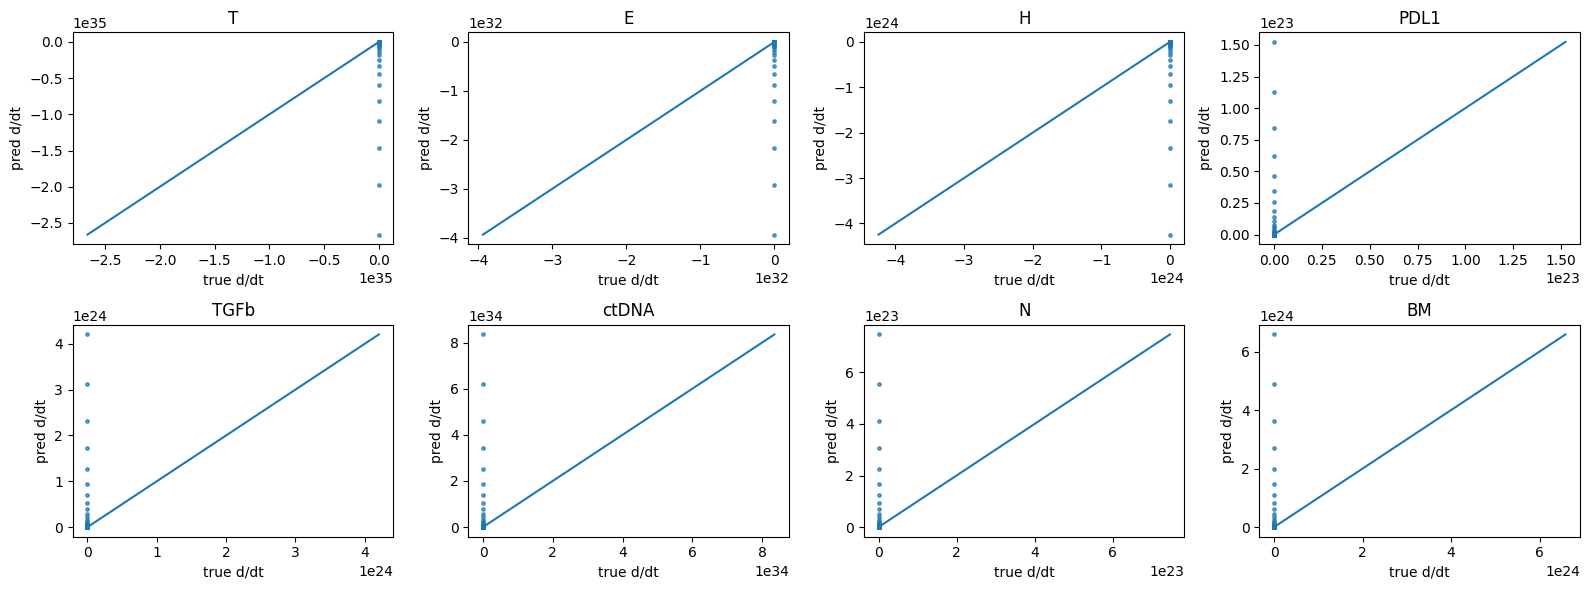

In [100]:
import torch
import matplotlib.pyplot as plt

# 1) Compute predicted derivatives using discovered coefficients
with torch.no_grad():
    dxdt_pred = Phi @ W.T   # [T, n_states]

# 2) Print MSE and R^2 per state
print("=== Derivative Fit Quality (per state) ===")
for k, name in enumerate(state_names):
    y    = dxdt_data[:, k]
    yhat = dxdt_pred[:, k]
    mse  = torch.mean((yhat - y)**2).item()
    var  = torch.var(y, unbiased=False).item()
    r2   = 1.0 - mse / (var + 1e-12)
    print(f"{name:6s} | MSE = {mse:.4e}   R^2 = {r2:.4f}")

# 3) Scatter plots: dx/dt_true vs dx/dt_pred for selected states
states_to_plot = ["T", "E", "H", "PDL1", "TGFb", "ctDNA", "N", "BM"]

n_plot = len(states_to_plot)
n_cols = 4
n_rows = int((n_plot + n_cols - 1) // n_cols)

plt.figure(figsize=(4*n_cols, 3*n_rows))

for idx, name in enumerate(states_to_plot):
    s_idx = state_index[name]
    y    = dxdt_data[:, s_idx].cpu()
    yhat = dxdt_pred[:, s_idx].cpu()

    min_val = min(y.min(), yhat.min()).item()
    max_val = max(y.max(), yhat.max()).item()

    plt.subplot(n_rows, n_cols, idx+1)
    plt.scatter(y, yhat, s=6, alpha=0.7)
    plt.plot([min_val, max_val], [min_val, max_val])  # ideal diagonal
    plt.xlabel("true d/dt")
    plt.ylabel("pred d/dt")
    plt.title(name)
    plt.tight_layout()

plt.show()


In [101]:
import torch

# 1) True parameters used to generate x_data (for comparison)
theta_true = get_teacher_params(model, device=device, dtype=dtype)

# 2) Learnable parameters: start from initial_guess if present, else from value
def init_learnable_theta(model, device=device, dtype=dtype):
    theta_train = {}
    for name, info in model["parameters"].items():
        if "initial_guess" in info:
            init_val = info["initial_guess"]
        elif "value" in info:
            init_val = info["value"]
        else:
            init_val = 0.1  # fallback

        theta_train[name] = torch.nn.Parameter(
            torch.tensor(init_val, dtype=dtype, device=device)
        )
    return theta_train

theta_train = init_learnable_theta(model)
# Randomly perturb initial guesses so they don't equal theta_true
for name, p in theta_train.items():
    with torch.no_grad():
        noise = 0.05 * torch.randn_like(p)  # 5% std
        p *= (1.0 + noise)

# Collect parameters into a list for the optimizer
optim_params = list(theta_train.values())

print(f"Number of learnable parameters: {len(optim_params)}")


Number of learnable parameters: 69


In [102]:
def simulate_with_theta(theta_dict):
    """
    Wrapper around simulate_teacher that takes a dict of learnable Parameters.
    """
    times_pred, x_pred = simulate_teacher(
        model, patient, theta_dict, u_schedule,
        device=device, dtype=dtype
    )
    return times_pred, x_pred


In [103]:
# Make sure x_data and times are on the right device/dtype
times   = times.to(device=device, dtype=dtype)
x_data  = x_data.to(device=device, dtype=dtype)

optimizer = torch.optim.Adam(optim_params, lr=1e-5)

num_iters   = 500
print_every = 50

for it in range(1, num_iters + 1):
    optimizer.zero_grad()

    _, x_pred = simulate_with_theta_prefix(theta_train)

    loss = torch.mean((x_pred - x_data_fit) ** 2)

    if torch.isnan(loss) or torch.isinf(loss):
        print(f"iter {it}: loss is {loss}, stopping early")
        break

    loss.backward()
    optimizer.step()

    if it % print_every == 0 or it == 1 or it == num_iters:
        print(f"iter {it:4d} | loss = {loss.item():.6e}")

KeyboardInterrupt: 

In [ ]:
print("\n=== Parameter recovery summary ===")
for name in sorted(theta_true.keys()):
    true_val   = float(theta_true[name].detach().cpu())
    est_val    = float(theta_train[name].detach().cpu())
    rel_error  = (est_val - true_val) / (true_val + 1e-12)
    print(f"{name:20s}  true = {true_val: .4e}   est = {est_val: .4e}   rel_err = {rel_error: .2%}")



=== Parameter recovery summary ===
EC50_Adr              true =  5.0000e-01   est =  nan   rel_err =  nan%
EC50_Cyc              true =  5.0000e-01   est =  nan   rel_err =  nan%
EC50_Tax              true =  5.0000e-01   est =  nan   rel_err =  nan%
Emax_Adr              true =  1.0000e+00   est =  nan   rel_err =  nan%
Emax_Cyc              true =  1.0000e+00   est =  nan   rel_err =  nan%
Emax_Tax              true =  1.0000e+00   est =  nan   rel_err =  nan%
K_BM                  true =  3.0000e-01   est =  nan   rel_err =  nan%
K_ET                  true =  2.0000e-01   est =  nan   rel_err =  nan%
K_Hboost_E            true =  3.0000e-01   est =  nan   rel_err =  nan%
K_IO                  true =  2.0000e-01   est =  nan   rel_err =  nan%
K_N                   true =  2.0000e-01   est =  2.0906e-01   rel_err =  4.53%
K_N_prolif            true =  2.0000e-01   est =  nan   rel_err =  nan%
K_N_use_E             true =  2.0000e-01   est =  nan   rel_err =  nan%
K_N_use_T           

In [ ]:
def compute_time_derivative(times, x):
    dt = times[1] - times[0]
    dxdt = torch.zeros_like(x)

    dxdt[1:-1] = (x[2:] - x[:-2]) / (2*dt)
    dxdt[0]    = (x[1] - x[0]) / dt
    dxdt[-1]   = (x[-1] - x[-2]) / dt
    return dxdt

dxdt_data = compute_time_derivative(times, x_data)


In [ ]:
T_full = times.shape[0]
T_sub  = min(T_full, 364)  # e.g. first 90 time steps

times_fit   = times[:T_sub]
x_data_fit  = x_data[:T_sub]
dxdt_fit    = dxdt_data[:T_sub]


In [ ]:
def f_teacher_batch(x_series, t_series, theta, u_fn):
    """
    x_series: [T_sub, n_states]
    t_series: [T_sub]
    theta: dict of tensors/Parameters
    u_fn: control schedule
    returns: [T_sub, n_states] of dx/dt
    """
    T_sub = x_series.shape[0]
    outs = []
    for i in range(T_sub):
        outs.append(f_teacher(x_series[i], t_series[i], theta, u_fn))
    return torch.stack(outs, dim=0)


In [ ]:
# True parameters you used to generate x_data
theta_true = get_teacher_params(model, device=device, dtype=dtype)

# Trainable copy: everything is a Tensor, then we upgrade one to Parameter
theta_train = {
    name: val.clone().detach().to(device=device, dtype=dtype)
    for name, val in theta_true.items()
}

# Make ONE learnable parameter (e.g., tumor growth rate)
theta_train["rT_max"] = torch.nn.Parameter(
    theta_true["rT_max"].clone().detach().to(device=device, dtype=dtype)
)

# Tiny perturbation so there's something to learn
with torch.no_grad():
    theta_train["rT_max"] *= (1.0 + 0.01 * torch.randn_like(theta_train["rT_max"]))

optim_params = [theta_train["rT_max"]]
print("Learning only:", optim_params)


Learning only: [Parameter containing:
tensor(0.0514, dtype=torch.float64, requires_grad=True)]


In [ ]:
times_fit  = times_fit.to(device=device, dtype=dtype)
x_data_fit = x_data_fit.to(device=device, dtype=dtype)
dxdt_fit   = dxdt_fit.to(device=device, dtype=dtype)


In [ ]:
optimizer   = torch.optim.Adam(optim_params, lr=1e-3)
num_iters   = 1000
print_every = 100

idx_T = state_index["T"]

for it in range(1, num_iters + 1):
    optimizer.zero_grad()

    # Predicted derivatives from current theta
    dxdt_pred = f_teacher_batch(x_data_fit, times_fit, theta_train, u_schedule)
    # Focus on T equation only
    y_true = dxdt_fit[:, idx_T]
    y_pred = dxdt_pred[:, idx_T]

    # Loss: MSE over time for dT/dt
    loss = torch.mean((y_pred - y_true)**2)

    if torch.isnan(loss) or torch.isinf(loss):
        print(f"iter {it}: loss is {loss}, stopping early")
        break

    loss.backward()
    optimizer.step()

    if it % print_every == 0 or it == 1 or it == num_iters:
        print(
            f"iter {it:4d} | loss = {loss.item():.6e} "
            f"| rT_max true = {theta_true['rT_max'].item():.4e} "
            f"| est = {theta_train['rT_max'].item():.4e}"
        )


iter    1 | loss = 4.584237e-05 | rT_max true = 5.0000e-02 | est = 5.0385e-02
iter  100 | loss = 4.236720e-05 | rT_max true = 5.0000e-02 | est = -4.4825e-02


KeyboardInterrupt: 

In [ ]:
print("\nFinal recovery for rT_max:")
print("True:", float(theta_true["rT_max"]))
print("Est :", float(theta_train["rT_max"].detach()))



Final recovery for rT_max:
True: 0.05
Est : -0.4173724402592014


Now I know that AD is working i just got a bad estimation because im trying to use one parameter to explain all the error


Now I going to scale up to T

In [ ]:
import torch
import matplotlib.pyplot as plt

# ----- 1. Numerical time derivative -----
def compute_time_derivative(times, x):
    dt = times[1] - times[0]
    dxdt = torch.zeros_like(x)

    dxdt[1:-1] = (x[2:] - x[:-2]) / (2*dt)
    dxdt[0]    = (x[1] - x[0]) / dt
    dxdt[-1]   = (x[-1] - x[-2]) / dt
    return dxdt

dxdt_data = compute_time_derivative(times, x_data)

# Use an early window (first 90 timepoints) for fitting
T_full = times.shape[0]
T_sub  = min(T_full, 364)

times_fit   = times[:T_sub]
x_data_fit  = x_data[:T_sub]
dxdt_fit    = dxdt_data[:T_sub]


In [ ]:
eps = 1e-8

# assumes you already have these helpers defined earlier, but repeating here is safe:
def Sat(x, K):
    return x / (K + x + eps)

def Hill(x, K, n):
    return x**n / (K**n + x**n + eps)

def g_N(N, theta):
    return Sat(N, theta["K_N_prolif"])

def g_BM(BM, theta):
    return BM**theta["n_BM"] / (theta["K_BM"]**theta["n_BM"] + BM**theta["n_BM"] + eps)

def g_TGFb(TGFb, theta):
    return Hill(TGFb, theta["K_TGFb"], theta["n_TGFb"])

def S_PDL1(PDL1, theta):
    return Hill(PDL1, theta["K_PDL1"], theta["n_PDL1"])

def S_IO(IO, theta):
    return Hill(IO, theta["K_IO"], theta["n_IO"])

def S_Adr(Adr, theta):
    return theta["Emax_Adr"] * Hill(Adr, theta["EC50_Adr"], theta["n_Adr"])

def S_Cyc(Cyc, theta):
    return theta["Emax_Cyc"] * Hill(Cyc, theta["EC50_Cyc"], theta["n_Cyc"])

def S_Tax(Tax, theta):
    return theta["Emax_Tax"] * Hill(Tax, theta["EC50_Tax"], theta["n_Tax"])

# ----- 2. Build term matrix for T equation -----
def build_T_term_matrix(x_series, t_series, theta):
    """
    x_series: [T_sub, n_states]
    t_series: [T_sub]
    theta: dict of (true) parameters
    returns:
        Phi_T: [T_sub, n_terms]
        term_names: list of length n_terms
    """
    T    = x_series[:, state_index["T"]]
    E    = x_series[:, state_index["E"]]
    H    = x_series[:, state_index["H"]]      # not strictly needed here but kept
    PDL1 = x_series[:, state_index["PDL1"]]
    TGFb = x_series[:, state_index["TGFb"]]
    ct   = x_series[:, state_index["ctDNA"]]
    Adr  = x_series[:, state_index["Adr"]]
    Cyc  = x_series[:, state_index["Cyc"]]
    Tax  = x_series[:, state_index["Tax"]]
    Tam  = x_series[:, state_index["Tam"]]
    IO   = x_series[:, state_index["IO"]]
    TIL  = x_series[:, state_index["TIL"]]
    N    = x_series[:, state_index["N"]]
    BM   = x_series[:, state_index["BM"]]

    # Helper signals (using true parameters)
    gN   = g_N(N, theta)
    SP   = S_PDL1(PDL1, theta)
    SIO  = S_IO(IO, theta)

    SAdr   = S_Adr(Adr, theta)
    SCyc   = S_Cyc(Cyc, theta)
    STax   = S_Tax(Tax, theta)
    Schemo = SAdr + SCyc + STax

    STam   = Sat(Tam, theta["K_Tam"])

    K_ET   = theta["K_ET"]

    # Terms (kernels) for dT/dt
    terms = []
    names = []

    # 0) constant
    terms.append(torch.ones_like(T))
    names.append("const")

    # 1) logistic-like proliferation kernel *without* the k_ET, chemo, etc.
    #    In the teacher ODE, dT has: rT_max * gN * (1 + k_PDboost_T * SP) * T * (1 - T)
    growth_kernel = gN * (1.0 + theta["k_PDboost_T"] * SP) * T * (1.0 - T)
    terms.append(growth_kernel)
    names.append("growth_logistic_kernel")

    # 2) immune kill kernel: (E*T)/(K_ET + T)
    immune_kernel = (E * T) / (K_ET + T + eps)
    terms.append(immune_kernel)
    names.append("immune_kill_kernel")

    # 3) chemo kill kernel: Schemo * T
    chemo_kernel = Schemo * T
    terms.append(chemo_kernel)
    names.append("chemo_kill_kernel")

    # 4) tam kill kernel: Sat(Tam)*T
    tam_kernel = STam * T
    terms.append(tam_kernel)
    names.append("tam_kill_kernel")

    # 5) simple linear T term (catch-all)
    terms.append(T)
    names.append("T_linear")

    Phi_T = torch.stack(terms, dim=1)  # [T_sub, n_terms]
    return Phi_T, names

theta_true = get_teacher_params(model, device=device, dtype=dtype)
Phi_T, term_names_T = build_T_term_matrix(x_data_fit, times_fit, theta_true)

print("Phi_T shape:", Phi_T.shape)
print("Terms:", term_names_T)


Phi_T shape: torch.Size([364, 6])
Terms: ['const', 'growth_logistic_kernel', 'immune_kill_kernel', 'chemo_kill_kernel', 'tam_kill_kernel', 'T_linear']


In [ ]:
# Target derivative for T
idx_T = state_index["T"]
dTdt_fit = dxdt_fit[:, idx_T]   # [T_sub]

# Trainable coefficients for terms in the T equation
n_terms_T = Phi_T.shape[1]
coeffs_T = torch.nn.Parameter(torch.zeros(n_terms_T, dtype=dtype, device=device))

optimizer = torch.optim.Adam([coeffs_T], lr=1e-2)
num_iters   = 2000
print_every = 200

for it in range(1, num_iters + 1):
    optimizer.zero_grad()
    dTdt_pred = Phi_T @ coeffs_T  # [T_sub]
    loss = torch.mean((dTdt_pred - dTdt_fit)**2)

    if torch.isnan(loss) or torch.isinf(loss):
        print(f"iter {it}: loss is {loss}, stopping early")
        break

    loss.backward()
    optimizer.step()

    if it % print_every == 0 or it == 1 or it == num_iters:
        print(f"iter {it:4d} | loss = {loss.item():.6e}")

print("\n=== Discovered coefficients for dT/dt ===")
for name, c in zip(term_names_T, coeffs_T.detach().cpu().numpy()):
    print(f"{name:25s}: {c: .4e}")


iter    1 | loss = 7.456168e-05
iter  200 | loss = 1.763571e-06
iter  400 | loss = 7.450217e-07
iter  600 | loss = 7.388570e-07
iter  800 | loss = 7.387100e-07
iter 1000 | loss = 7.385379e-07
iter 1200 | loss = 7.383366e-07
iter 1400 | loss = 7.381045e-07
iter 1600 | loss = 7.378399e-07
iter 1800 | loss = 7.375406e-07
iter 2000 | loss = 7.379011e-07

=== Discovered coefficients for dT/dt ===
const                    :  1.8405e-04
growth_logistic_kernel   : -6.0985e-01
immune_kill_kernel       :  3.9198e-01
chemo_kill_kernel        : -1.2234e+00
tam_kill_kernel          :  0.0000e+00
T_linear                 : -6.8643e-01


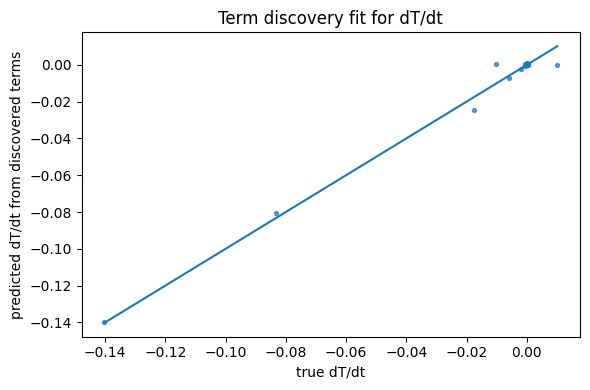

In [ ]:
with torch.no_grad():
    dTdt_pred = Phi_T @ coeffs_T

plt.figure(figsize=(6,4))
plt.scatter(dTdt_fit.cpu(), dTdt_pred.cpu(), s=8, alpha=0.7)
min_val = min(dTdt_fit.min(), dTdt_pred.min()).item()
max_val = max(dTdt_fit.max(), dTdt_pred.max()).item()
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("true dT/dt")
plt.ylabel("predicted dT/dt from discovered terms")
plt.title("Term discovery fit for dT/dt")
plt.tight_layout()
plt.show()


T works so now Im going to do the rest {E,H,PDL1,TGFb,ctDNA,Adr,Cyc,Tax,Tam,IO,TIL,N,BM}

In [ ]:
def standardize_phi(Phi, const_col_idx=0):
    """
    Phi: [T_sub, n_terms]
    const_col_idx: index of constant term to leave unstandardized.
    Returns:
        Phi_std, means, stds  (all [n_terms])
    """
    T_sub, n_terms = Phi.shape
    means = Phi.mean(dim=0)
    stds  = Phi.std(dim=0)

    # avoid zero std
    stds = torch.where(stds < 1e-8, torch.ones_like(stds), stds)

    Phi_std = (Phi - means) / stds

    # put constant column back to original (no standardization)
    if const_col_idx is not None:
        Phi_std[:, const_col_idx] = Phi[:, const_col_idx]
        means[const_col_idx] = 0.0
        stds[const_col_idx]  = 1.0

    return Phi_std, means, stds


In [ ]:
def build_term_matrices_all():
    Phi_dict   = {}
    names_dict = {}
    stats_dict = {}  # for means/stds if you ever want to de-standardize

    # ------------------- T equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(T)); names.append("const")

    growth_T_kernel = gN * (1.0 + theta_true["k_PDboost_T"] * SP) * T * (1.0 - T)
    terms.append(growth_T_kernel); names.append("growth_logistic_kernel")

    immune_T_kernel = (E * T) / (K_ET + T + eps)
    terms.append(immune_T_kernel); names.append("immune_kill_kernel")

    chemo_T_kernel = Schemo * T
    terms.append(chemo_T_kernel);  names.append("chemo_kill_kernel")

    tam_T_kernel = STam * T
    terms.append(tam_T_kernel);    names.append("tam_kill_kernel")

    Phi_T_raw = torch.stack(terms, dim=1)
    Phi_T, mu_T, std_T = standardize_phi(Phi_T_raw, const_col_idx=0)
    Phi_dict["T"]   = Phi_T
    names_dict["T"] = names
    stats_dict["T"] = (mu_T, std_T)

    # ------------------- E equation (FACTORED E) -------------------
    terms = []
    names = []

    # constant term in the "per-capita" bracket
    terms.append(torch.ones_like(E)); names.append("const")

    # NOTE: these kernels NO LONGER include E
    growth_E_kernel = (
    gN * gBM * (1.0 - theta_true["phi_TGFb"] * gTGF)
    * (1.0 + theta_true["gamma_IO"] * SIO)
    )
    terms.append(growth_E_kernel); names.append("growth_E_kernel")

    stim_T_E_kernel = Sat(T, theta_true["K_Tstim_E"])
    terms.append(stim_T_E_kernel); names.append("stim_T_to_E_kernel")

    stim_H_E_kernel = Sat(H, theta_true["K_Hboost_E"])
    terms.append(stim_H_E_kernel); names.append("stim_H_to_E_kernel")

    loss_E_kernel   = (1.0 + SP)
    terms.append(loss_E_kernel);   names.append("loss_E_kernel")

    Phi_E_raw = torch.stack(terms, dim=1)
    Phi_E, mu_E, std_E = standardize_phi(Phi_E_raw, const_col_idx=0)
    Phi_dict["E"]   = Phi_E
    names_dict["E"] = names
    stats_dict["E"] = (mu_E, std_E)


    # ------------------- H equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(H)); names.append("const")
    growth_H_kernel = gN * gBM * (1.0 - theta_true["phi_TGFb"] * gTGF) * H
    stim_T_H_kernel = Sat(T, theta_true["K_Tstim_H"]) * H
    loss_H_kernel   = H

    terms.append(growth_H_kernel); names.append("growth_H_kernel")
    terms.append(stim_T_H_kernel); names.append("stim_T_to_H_kernel")
    terms.append(loss_H_kernel);   names.append("loss_H_kernel")

    Phi_H_raw = torch.stack(terms, dim=1)
    Phi_H, mu_H, std_H = standardize_phi(Phi_H_raw, const_col_idx=0)
    Phi_dict["H"]   = Phi_H
    names_dict["H"] = names
    stats_dict["H"] = (mu_H, std_H)

    # ------------------- PDL1 equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(PDL1)); names.append("const")
    terms.append(Sat(T, theta_true["K_PDL1_up_T"])); names.append("Sat_T_up_PDL1_kernel")
    terms.append(Sat(E, theta_true["K_PDL1_up_E"])); names.append("Sat_E_up_PDL1_kernel")
    terms.append(PDL1);                              names.append("PDL1_linear")
    terms.append(SIO * PDL1);                        names.append("IO_block_PDL1_kernel")

    Phi_P_raw = torch.stack(terms, dim=1)
    Phi_P, mu_P, std_P = standardize_phi(Phi_P_raw, const_col_idx=0)
    Phi_dict["PDL1"]   = Phi_P
    names_dict["PDL1"] = names
    stats_dict["PDL1"] = (mu_P, std_P)

    # ------------------- TGFb equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(TGFb)); names.append("const")
    terms.append(T);                     names.append("T_secretion_kernel")
    terms.append(TGFb);                 names.append("TGFb_decay_kernel")

    Phi_TGF_raw = torch.stack(terms, dim=1)
    Phi_TGF, mu_TGF, std_TGF = standardize_phi(Phi_TGF_raw, const_col_idx=0)
    Phi_dict["TGFb"]   = Phi_TGF
    names_dict["TGFb"] = names
    stats_dict["TGFb"] = (mu_TGF, std_TGF)

    # ------------------- ctDNA equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(ct)); names.append("const")
    terms.append(T);                   names.append("T_source_kernel")
    terms.append(ct);                  names.append("ct_clear_kernel")

    Phi_ct_raw = torch.stack(terms, dim=1)
    Phi_ct, mu_ct, std_ct = standardize_phi(Phi_ct_raw, const_col_idx=0)
    Phi_dict["ctDNA"]   = Phi_ct
    names_dict["ctDNA"] = names
    stats_dict["ctDNA"] = (mu_ct, std_ct)

    # ------------------- Adr PK equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(Adr)); names.append("const")
    terms.append(u_Adr_series);         names.append("u_Adr_kernel")
    terms.append(Adr);                  names.append("Adr_clear_kernel")

    Phi_Adr_raw = torch.stack(terms, dim=1)
    Phi_Adr, mu_Adr, std_Adr = standardize_phi(Phi_Adr_raw, const_col_idx=0)
    Phi_dict["Adr"]   = Phi_Adr
    names_dict["Adr"] = names
    stats_dict["Adr"] = (mu_Adr, std_Adr)

    # ------------------- Cyc PK equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(Cyc)); names.append("const")
    terms.append(u_Cyc_series);         names.append("u_Cyc_kernel")
    terms.append(Cyc);                  names.append("Cyc_clear_kernel")

    Phi_Cyc_raw = torch.stack(terms, dim=1)
    Phi_Cyc, mu_Cyc, std_Cyc = standardize_phi(Phi_Cyc_raw, const_col_idx=0)
    Phi_dict["Cyc"]   = Phi_Cyc
    names_dict["Cyc"] = names
    stats_dict["Cyc"] = (mu_Cyc, std_Cyc)

    # ------------------- Tax PK equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(Tax)); names.append("const")
    terms.append(u_Tax_series);         names.append("u_Tax_kernel")
    terms.append(Tax);                  names.append("Tax_clear_kernel")

    Phi_Tax_raw = torch.stack(terms, dim=1)
    Phi_Tax, mu_Tax, std_Tax = standardize_phi(Phi_Tax_raw, const_col_idx=0)
    Phi_dict["Tax"]   = Phi_Tax
    names_dict["Tax"] = names
    stats_dict["Tax"] = (mu_Tax, std_Tax)

    # ------------------- Tam PK equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(Tam)); names.append("const")
    terms.append(u_Tam_series);         names.append("u_Tam_kernel")
    terms.append(Tam);                  names.append("Tam_clear_kernel")

    Phi_Tam_raw = torch.stack(terms, dim=1)
    Phi_Tam, mu_Tam, std_Tam = standardize_phi(Phi_Tam_raw, const_col_idx=0)
    Phi_dict["Tam"]   = Phi_Tam
    names_dict["Tam"] = names
    stats_dict["Tam"] = (mu_Tam, std_Tam)

    # ------------------- IO PK equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(IO)); names.append("const")
    terms.append(u_IO_series);         names.append("u_IO_kernel")
    terms.append(IO);                  names.append("IO_clear_kernel")

    Phi_IO_raw = torch.stack(terms, dim=1)
    Phi_IO, mu_IO, std_IO = standardize_phi(Phi_IO_raw, const_col_idx=0)
    Phi_dict["IO"]   = Phi_IO
    names_dict["IO"] = names
    stats_dict["IO"] = (mu_IO, std_IO)

    # ------------------- TIL equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(TIL)); names.append("const")
    terms.append(u_TIL_series);         names.append("u_TIL_kernel")
    terms.append(TIL);                  names.append("TIL_decay_kernel")

    Phi_TIL_raw = torch.stack(terms, dim=1)
    Phi_TIL, mu_TIL, std_TIL = standardize_phi(Phi_TIL_raw, const_col_idx=0)
    Phi_dict["TIL"]   = Phi_TIL
    names_dict["TIL"] = names
    stats_dict["TIL"] = (mu_TIL, std_TIL)

    # ------------------- N equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(N)); names.append("const")
    terms.append(N);                  names.append("N_linear")

    Tumor_use = N * T / (theta_true["K_N_use_T"] + T + eps)
    Eff_use   = N * E / (theta_true["K_N_use_E"] + E + eps)

    terms.append(Tumor_use);          names.append("Tumor_use_kernel")
    terms.append(Eff_use);            names.append("Eff_use_kernel")
    terms.append(Schemo * N);         names.append("chemo_N_kernel")

    Phi_N_raw = torch.stack(terms, dim=1)
    Phi_N, mu_N, std_N = standardize_phi(Phi_N_raw, const_col_idx=0)
    Phi_dict["N"]   = Phi_N
    names_dict["N"] = names
    stats_dict["N"] = (mu_N, std_N)

    # ------------------- BM equation -------------------
    terms = []
    names = []

    terms.append(torch.ones_like(BM)); names.append("const")
    terms.append(BM);                  names.append("BM_linear")
    terms.append(Schemo * BM);         names.append("chemo_BM_kernel")
    Support_IO  = SIO * (1.0 - BM)
    Support_TIL = Sat(TIL, theta_true["K_TIL"]) * (1.0 - BM)
    terms.append(Support_IO);          names.append("IO_support_kernel")
    terms.append(Support_TIL);         names.append("TIL_support_kernel")

    Phi_BM_raw = torch.stack(terms, dim=1)
    Phi_BM, mu_BM, std_BM = standardize_phi(Phi_BM_raw, const_col_idx=0)
    Phi_dict["BM"]   = Phi_BM
    names_dict["BM"] = names
    stats_dict["BM"] = (mu_BM, std_BM)

    return Phi_dict, names_dict, stats_dict

Phi_dict, names_dict, stats_dict = build_term_matrices_all()


NameError: name 'T' is not defined

In [ ]:
def fit_single_state(state_name, Phi_s, y_s, term_names, lr=1e-2,
                     num_iters=2000, print_every=400, ridge_lambda=1e-4):
    """
    Fit coefficients for dX/dt of one state:
    y_s ≈ Phi_s @ coeffs
    """
    n_terms = Phi_s.shape[1]
    coeffs = torch.nn.Parameter(torch.zeros(n_terms, dtype=dtype, device=device))
    opt = torch.optim.Adam([coeffs], lr=lr)

    for it in range(1, num_iters + 1):
        opt.zero_grad()
        if state_name == "E":
            # per-capita bracket * E(t)
            E_series = states_fit["E"][:Phi_s.shape[0]]  # [T_sub]
            bracket  = Phi_s @ coeffs                    # [T_sub]
            y_pred   = bracket * E_series
        else:
            y_pred = Phi_s @ coeffs
        mse = torch.mean((y_pred - y_s)**2)
        ridge = ridge_lambda * torch.sum(coeffs**2)
        loss = mse + ridge

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"[{state_name}] iter {it}: loss is {loss}, stopping")
            break

        loss.backward()
        opt.step()

        if it % print_every == 0 or it == 1 or it == num_iters:
            print(f"[{state_name}] iter {it:4d} | mse = {mse.item():.6e} | loss = {loss.item():.6e}")

    return coeffs.detach()


# ---- run for all states ----
coeffs_dict = {}

for s in state_names:
    Phi_s = Phi_dict[s]                  # [T_sub, n_terms]
    idx_s = state_index[s]
    y_s   = dxdt_fit[:, idx_s]           # [T_sub]
    term_names = names_dict[s]

    print(f"\n=== Fitting d{s}/dt ===")
    coeffs_s = fit_single_state(s, Phi_s, y_s, term_names,
                                lr=1e-2, num_iters=2000,
                                print_every=500, ridge_lambda=1e-4)
    coeffs_dict[s] = coeffs_s



=== Fitting dT/dt ===
[T] iter    1 | mse = 3.015606e-04 | loss = 3.015606e-04
[T] iter  500 | mse = 3.142323e-06 | loss = 3.201743e-06
[T] iter 1000 | mse = 3.142323e-06 | loss = 3.201743e-06
[T] iter 1500 | mse = 6.521142e-06 | loss = 6.581921e-06
[T] iter 2000 | mse = 4.125340e-06 | loss = 4.186340e-06

=== Fitting dE/dt ===
[E] iter    1 | mse = 2.206223e+04 | loss = 2.206223e+04
[E] iter  500 | mse = 9.082697e-01 | loss = 9.082711e-01
[E] iter 1000 | mse = 1.650026e-01 | loss = 1.650043e-01
[E] iter 1500 | mse = 1.648091e-01 | loss = 1.648108e-01
[E] iter 2000 | mse = 1.648054e-01 | loss = 1.648071e-01

=== Fitting dH/dt ===
[H] iter    1 | mse = 3.840282e-05 | loss = 3.840282e-05
[H] iter  500 | mse = 4.796001e-06 | loss = 4.799852e-06
[H] iter 1000 | mse = 4.796001e-06 | loss = 4.799852e-06
[H] iter 1500 | mse = 4.796001e-06 | loss = 4.799852e-06
[H] iter 2000 | mse = 4.796001e-06 | loss = 4.799852e-06

=== Fitting dPDL1/dt ===
[PDL1] iter    1 | mse = 1.158557e-03 | loss = 1.1

In [ ]:
print("\n================ Discovered coefficients (per equation) ================\n")
for s in state_names:
    print(f"--- d{s}/dt ---")
    names_s = names_dict[s]
    coef_s  = coeffs_dict[s].cpu().numpy()
    for name, c in zip(names_s, coef_s):
        print(f"{name:30s}: {c: .4e}")
    print()

# ---- Scatter plots: dX/dt_true vs dX/dt_pred ----
n_states = len(state_names)
n_cols   = 4
n_rows   = int((n_states + n_cols - 1) // n_cols)

plt.figure(figsize=(4*n_cols, 3*n_rows))

plot_idx = 1
for s in state_names:
    Phi_s = Phi_dict[s]
    coef_s = coeffs_dict[s]
    idx_s = state_index[s]

    y_true = dxdt_fit[:, idx_s].detach().cpu()
    y_pred = (Phi_s @ coef_s).detach().cpu()

    min_val = min(y_true.min(), y_pred.min()).item()
    max_val = max(y_true.max(), y_pred.max()).item()

    plt.subplot(n_rows, n_cols, plot_idx)
    plt.scatter(y_true, y_pred, s=8, alpha=0.7)
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.title(f"d{s}/dt")
    plt.xlabel("true")
    plt.ylabel("pred")
    plot_idx += 1

plt.tight_layout()
plt.show()



================ Discovered coefficients (per equation) ================

--- dT/dt ---


NameError: name 'names_dict' is not defined

Now Im moving on to parameter learning


In [ ]:


import json, math
import torch
import matplotlib.pyplot as plt

device = "cpu"
dtype  = torch.float64# ------------------------------------------------------------------
# Learnable parameter container: theta_learn
# ------------------------------------------------------------------
theta_learn = torch.nn.ParameterDict()

for name, val in theta.items():
    # multiplicative noise around 1.0
    noise = 0.15 * torch.randn_like(val)   # 15% noise
    init_val = val.clone().detach() * (1.0 + noise)

    # or: init_val = val.clone().detach() + 0.1 * torch.randn_like(val)

    theta_learn[name] = torch.nn.Parameter(init_val.to(device=device, dtype=dtype))

# (Optional) example: freeze some parameters if you want
# for name in ["n_Adr", "n_Cyc", "n_Tax"]:
#     theta_learn[name].requires_grad_(False)

theta_learn


ParameterDict(
    (rT_max): Parameter containing: [torch.DoubleTensor of size ]
    (k_ET): Parameter containing: [torch.DoubleTensor of size ]
    (K_ET): Parameter containing: [torch.DoubleTensor of size ]
    (k_Tam_ERPR): Parameter containing: [torch.DoubleTensor of size ]
    (K_Tam): Parameter containing: [torch.DoubleTensor of size ]
    (rE_max): Parameter containing: [torch.DoubleTensor of size ]
    (rH_max): Parameter containing: [torch.DoubleTensor of size ]
    (delta_E): Parameter containing: [torch.DoubleTensor of size ]
    (delta_H): Parameter containing: [torch.DoubleTensor of size ]
    (k_T_to_E): Parameter containing: [torch.DoubleTensor of size ]
    (K_Tstim_E): Parameter containing: [torch.DoubleTensor of size ]
    (k_T_to_H): Parameter containing: [torch.DoubleTensor of size ]
    (K_Tstim_H): Parameter containing: [torch.DoubleTensor of size ]
    (k_H_to_E): Parameter containing: [torch.DoubleTensor of size ]
    (K_Hboost_E): Parameter containing: [torch.D

In [ ]:
# ------------------------------------------------------------------
# Optional: choose which states to fit (e.g. T and ctDNA only)
# ------------------------------------------------------------------
fit_state_names = ["T", "ctDNA"]   # change this list if you want more

state_mask = torch.zeros(1, n_states, dtype=dtype, device=device)

# Turn ON only the states you want to fit
for s in fit_state_names:
    idx = state_index[s]          # lookup integer index
    state_mask[0, idx] = 1.0      # enable mask on that state

state_mask


tensor([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)

In [ ]:
# ------------------------------------------------------------------
# Parameter-fitting loss: compare simulated vs teacher x_data
# ------------------------------------------------------------------
def loss_fit(theta_learn, x_data, u_fn=u_schedule, state_mask=None):
    """
    theta_learn : ParameterDict mapping parameter name -> torch.nn.Parameter
    x_data      : [T, n_states] tensor of teacher/observed trajectories
    u_fn        : control schedule function u_fn(t) -> dict of doses
    state_mask  : [1, n_states] tensor with 1 for states to include, 0 to ignore
                  If None, defaults to all ones.
    """
    if state_mask is None:
        # fit all states by default
        mask = torch.ones(1, n_states, dtype=dtype, device=device)
    else:
        mask = state_mask

    # Simulate with current parameter guess
    times_sim, x_sim = simulate_teacher(
        model=model,
        patient=patient,
        theta=theta_learn,   # learnable parameters
        u_fn=u_fn,
        device=device,
        dtype=dtype,
    )

    # Ensure shapes match
    assert x_sim.shape == x_data.shape, f"shape mismatch: {x_sim.shape} vs {x_data.shape}"

    # Mean squared error over selected states and all timepoints
    diff = x_sim - x_data
    diff2 = diff * diff

    # Apply mask over state dimension (broadcast over time)
    diff2_masked = diff2 * mask  # [T, n_states]

    # Avoid dividing by zero if mask is weird
    denom = mask.sum() * x_data.shape[0]
    mse = diff2_masked.sum() / denom

    # --------------------------------------------------------------
    # Optional: parameter regularization / priors
    # --------------------------------------------------------------
    reg = 0.0
    # Example: very light L2 on a subset of parameters
    # for name in ["k_ET", "K_ET", "K_N", "K_BM"]:
    #     reg = reg + 1e-4 * (theta_learn[name] ** 2)

    loss = mse + reg
    return loss


In [ ]:
print(state_mask.sum())

tensor(2., dtype=torch.float64)


In [ ]:
# ------------------------------------------------------------------
# Training loop for parameter fitting
# ------------------------------------------------------------------
optimizer = torch.optim.Adam(theta_learn.parameters(), lr=1e-3)

num_iters   = 1000
print_every = 100

for it in range(1, num_iters + 1):
    optimizer.zero_grad()

    loss = loss_fit(theta_learn, x_data, u_fn=u_schedule, state_mask=state_mask)
    loss.backward()
    optimizer.step()

    if it % print_every == 0 or it == 1 or it == num_iters:
        with torch.no_grad():
            print(f"[iter {it:4d}] loss_fit = {loss.item():.6f}")


[iter    1] loss_fit = 0.000001


KeyboardInterrupt: 

In [ ]:
# Indices for plotting
idx_T     = state_index["T"]
idx_ctDNA = state_index["ctDNA"]


In [ ]:
import torch
torch.save({"times": times, "x_data": x_data}, "synthetic.pt")


In [ ]:
times.shape, x_data.shape
times[:10]
x_data[:10]

tensor([[1.8000e-01, 3.0000e-01, 5.0000e-01, 5.0000e-01, 0.0000e+00, 3.0000e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         5.0000e-01, 8.0000e-01],
        [3.9747e-02, 3.5117e-01, 5.1860e-01, 5.9478e-01, 2.2389e-02, 2.9705e-02,
         7.3967e-01, 7.3967e-01, 0.0000e+00, 0.0000e+00, 3.9248e-01, 0.0000e+00,
         4.6670e-01, 6.5087e-01],
        [1.3681e-02, 3.9192e-01, 5.2427e-01, 5.8306e-01, 2.4105e-02, 2.4929e-02,
         6.0559e-01, 6.0559e-01, 0.0000e+00, 0.0000e+00, 3.5513e-01, 0.0000e+00,
         5.4196e-01, 5.2011e-01],
        [4.7574e-03, 4.3464e-01, 5.2834e-01, 5.7795e-01, 2.3821e-02, 2.0601e-02,
         4.9582e-01, 4.9582e-01, 0.0000e+00, 0.0000e+00, 3.2133e-01, 0.0000e+00,
         5.7378e-01, 4.7082e-01],
        [1.6719e-03, 4.8081e-01, 5.3182e-01, 5.8111e-01, 2.2954e-02, 1.6929e-02,
         4.0594e-01, 4.0594e-01, 0.0000e+00, 0.0000e+00, 2.9076e-01, 0.0000e+00,
         5.8323e-01, 4.6087e-01],
        [6.0155e-04,

In [ ]:
import torch
import matplotlib.pyplot as plt

with open("synthetic.pt") as f:
    data = pt.load(f)
# Load the synthetic data file

times = data["times"]
x_data = data["x_data"]

# Plot T and ctDNA if available
# Try to infer indices if typical ordering: T is index 0, ctDNA maybe index 5?
# But let's just plot all state trajectories in subplots.

num_states = x_data.shape[1]

plt.figure(figsize=(14, 3 * ((num_states + 2) // 3)))

for i in range(num_states):
    plt.subplot((num_states + 2) // 3, 3, i+1)
    plt.plot(times, x_data[:, i])
    plt.title(f"State {i}")
    plt.xlabel("time")
    plt.ylabel(f"x[{i}]")

plt.tight_layout()
plt.show()

NameError: name 'pt' is not defined

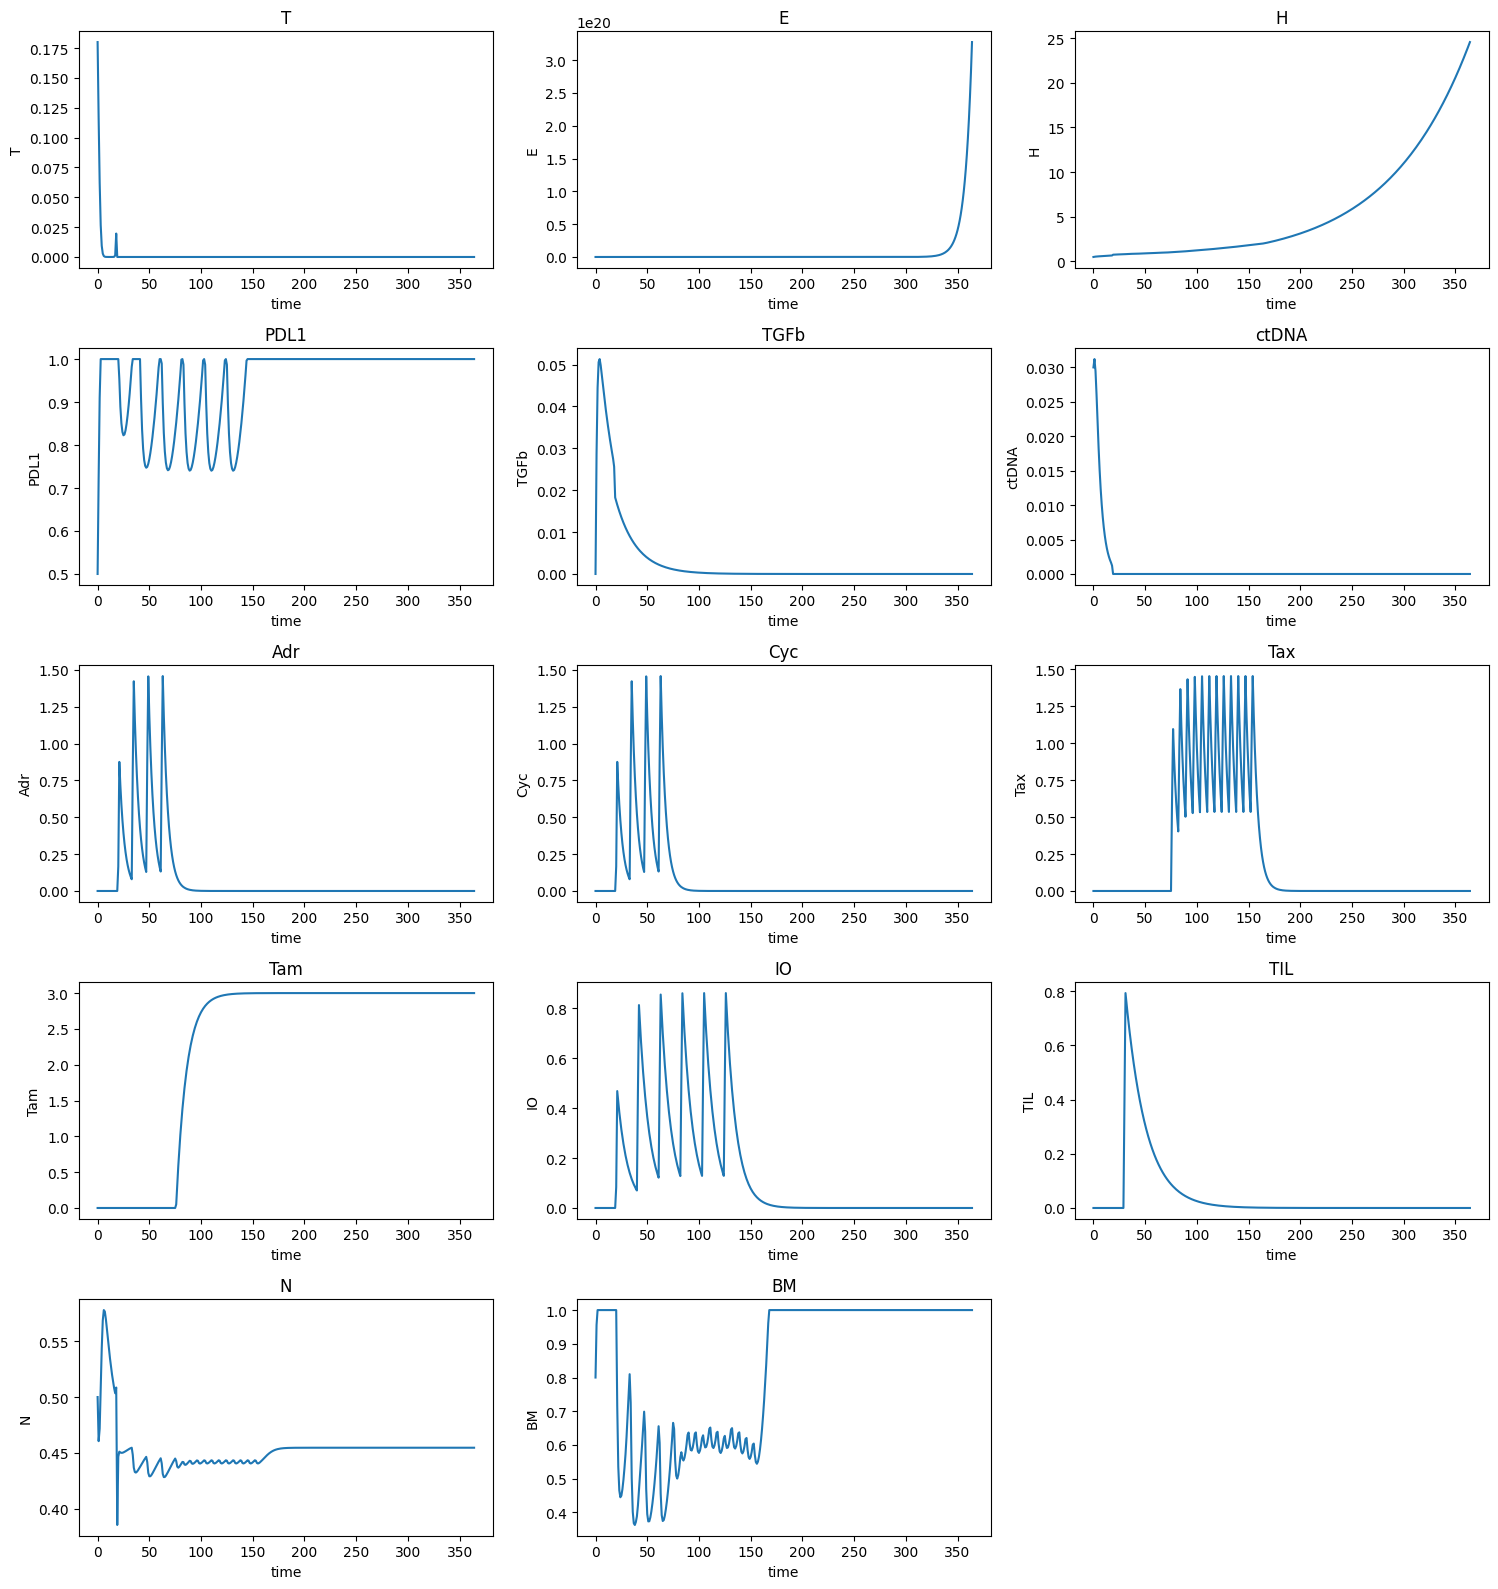

In [104]:
import matplotlib.pyplot as plt
import torch

# Ensure CPU
t = times.detach().cpu()
X = x_data.detach().cpu()

# Get state names in correct order
try:
    state_names = list(model["states"].keys())
except:
    # Fallback if model isn't loaded in this cell
    state_names = [f"state_{i}" for i in range(X.shape[1])]

T_len, n_states = X.shape
n_cols = 3
n_rows = (n_states + n_cols - 1) // n_cols  # ceil division

plt.figure(figsize=(5 * n_cols, 3.2 * n_rows))

for i in range(n_states):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(t, X[:, i])
    plt.xlabel("time")
    plt.ylabel(state_names[i])
    plt.title(state_names[i])

plt.tight_layout()
plt.show()


In [ ]:
idx_T = state_index["T"]
print("Tumor first 10:", x_data[:10, idx_T])

Tumor first 10: tensor([1.8000e-01, 3.9747e-02, 1.3681e-02, 4.7574e-03, 1.6719e-03, 6.0155e-04,
        2.2602e-04, 9.1094e-05, 4.0792e-05, 2.1201e-05], dtype=torch.float64)
